In [34]:
import json
import pandas as pd
import os
from datetime import datetime

# Takes date of birth from demographic (MIGHT NEED TO REMOVE)
def dob_to_age(dob_str):
    date_formats = ["%m/%d/%Y", "%d/%m/%Y"]
    for fmt in date_formats:
        try:
            dob = datetime.strptime(dob_str, fmt)
            break
        except ValueError:
            continue
    else:
        raise ValueError("DOB format not recognized. Use MM-DD-YYYY or DD-MM-YYYY.")
    today = datetime.today()
    age = today.year - dob.year - ((today.month, today.day) < (dob.month, dob.day))
    return age


main_folder = '/Users/rohinpalsule/Downloads/mstTest'  # **************** Change this to your actual path *****************
df_total = []
df_total_new = []
# The code below is super super messy but it works at some point i'll clean it but its basically looking at two diff directories alphabetized
for result_folder in sorted(os.listdir(main_folder)):
    result_path = os.path.join(main_folder, result_folder)
    if os.path.isdir(result_path) and not result_folder.startswith('.'):
        if os.path.isdir(result_path):
            comp_folders = sorted(
                [f for f in os.listdir(result_path)
                if os.path.isdir(os.path.join(result_path, f))]
            )
            if len(comp_folders) >= 3: 
                if len(comp_folders) != 6:
                    print(f"Number of subfolders in Participant folder: {len(comp_folders)}")
                target_comp = comp_folders[1]
                data_path = os.path.join(result_path, target_comp, 'data.txt')
                if os.path.exists(data_path):
                    with open(data_path, 'r') as file:
                        contents = file.read()
                else:
                    print(f"No data.txt in {data_path}")
            else:
                print(f"Not enough comp folders in {result_path}")
        with open(data_path, 'r') as file:
            data = json.load(file)
        df = pd.DataFrame(data)
        df['idcode'] = df['response'].apply(lambda x: x['idcode'])
    # I basically repeated the chunk bc was too lazy to change it im sorry
    if os.path.isdir(result_path) and not result_folder.startswith('.'):
        if os.path.isdir(result_path):
            comp_folders = sorted(
                [f for f in os.listdir(result_path)
                if os.path.isdir(os.path.join(result_path, f))]
            )
            if len(comp_folders) >= 3:
                target_comp = comp_folders[4]
                data_path = os.path.join(result_path, target_comp, 'data.txt')
                if os.path.exists(data_path):
                    with open(data_path, 'r') as file:
                        contents = file.read()
                else:
                    print(f"No data.txt in {data_path}")
            else:
                print(f"Not enough comp folders in {result_path}")
        with open(data_path, 'r') as file:
            data = json.load(file)
        df_data = pd.DataFrame(data)
        # Extracts REC and LDI
        df['REC'] = df_data[~df_data['summary'].isna()]['summary'].str.extract(r"REC, (-?[\d.]+)").reset_index(drop='index')
        df['LDI'] = df_data[~df_data['summary'].isna()]['summary'].str.extract(r"LDI, (-?[\d.]+)").reset_index(drop='index')
        df_data = df_data[df_data['stimulus'].fillna('').astype(str).str.startswith('Set5_rs')]
        df['Unrealistic RT'] = len(df_data[(df_data['rt'] < 0)|(df_data['rt'] > 7000)]['rt'])
        df['Max RT'] = df_data['rt'].max()
        df_total_new.append(df_data)
        df_total.append(df)
df_combined = pd.concat(df_total)
df_new = pd.concat(df_total_new)
new_df = pd.DataFrame()

df_demcomb = []
# Yes I in fact copied it a third time (theres another one spoiler alert)
for result_folder in sorted(os.listdir(main_folder)):
    result_path = os.path.join(main_folder, result_folder)
    if os.path.isdir(result_path) and not result_folder.startswith('.'):
        if os.path.isdir(result_path):
            comp_folders = sorted(
                [f for f in os.listdir(result_path)
                if os.path.isdir(os.path.join(result_path, f))]
            )
            if len(comp_folders) >= 3:
                target_comp = comp_folders[4]
                data_path = os.path.join(result_path, target_comp, 'data.txt')
                if os.path.exists(data_path):
                    with open(data_path, 'r') as file:
                        contents = file.read()
                else:
                    print(f"No data.txt in {data_path}")
            else:
                print(f"Not enough comp folders in {result_path}")
        with open(data_path, 'r') as file:
            data = json.load(file)
        df_dem = pd.DataFrame(data)
        # df_dem['Age'] = dob_to_age(df_dem['response'].values[0]['dob'])
        df_demcomb.append(df_dem)


demPath = '/Users/rohinpalsule/Downloads/mstDemographics'
dem_app = []
for result_folder in os.listdir(demPath):
    dem_ind = pd.read_csv(os.path.join(demPath,result_folder),on_bad_lines='skip')
    dem_app.append(dem_ind)
df_dem_new = pd.concat(dem_app)
df_dem_new = df_dem_new[['Participant id','Age']]
df_dem_new = df_dem_new.rename(columns={'Participant id':'idcode'})
df_dem_new

# Get unmatched IDs (those in df_combined but not in df_dem_new)
unmatched_ids = df_combined[~df_combined['idcode'].isin(df_dem_new['idcode'])]['idcode'].unique()

if unmatched_ids.size >0:
    print("Unmatched IDs:")
    print(unmatched_ids)
else:
    print("All IDs found in Demographics!")

df_combined = df_combined.merge(df_dem_new, on='idcode', how='left')
# Clean df that is nice and pretty and ignores everything above
df_combined = df_combined[['idcode','REC','LDI','Unrealistic RT','Age','Max RT']].reset_index(drop='index')
df_combined['LDI'] = df_combined['LDI'].astype(float)
df_combined['REC'] = df_combined['REC'].astype(float)
df_combined['Age'] = df_combined['Age'].astype(int)


All IDs found in Demographics!


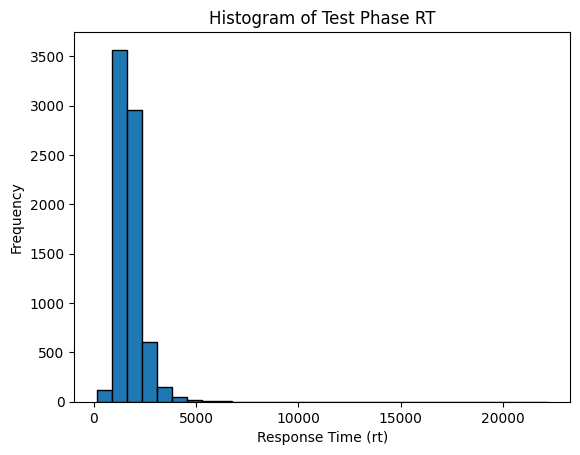

In [17]:
# Histogram of TEST PHASE RT
import matplotlib.pyplot as plt

rt = df_new['rt'].dropna()

plt.hist(rt, bins=30, edgecolor='black')
plt.xlabel('Response Time (rt)')
plt.ylabel('Frequency')
plt.title('Histogram of Test Phase RT')
plt.show()

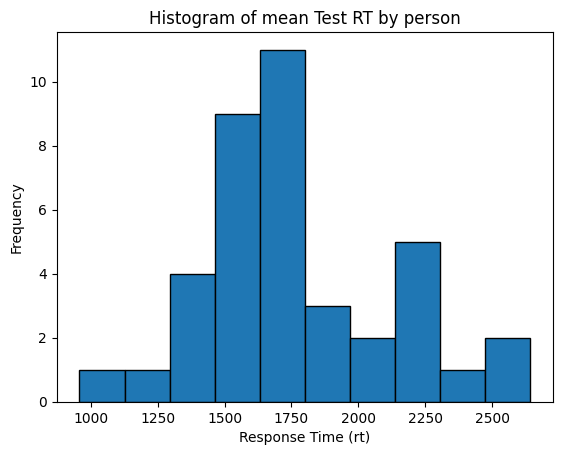

In [18]:
# Histogram of mean Test RT by person
rt_sub = df_new.groupby('subject')['rt'].mean()
plt.hist(rt_sub, bins=10, edgecolor='black')
plt.xlabel('Response Time (rt)')
plt.ylabel('Frequency')
plt.title('Histogram of mean Test RT by person')
plt.show()

In [19]:
# The filters!
cond1 = df_combined['REC'] <= 0.5
cond2 = df_combined['LDI'] < 0.0
cond3 = df_combined['Unrealistic RT'] > 0
cond4 = df_combined['Max RT'] > 10000
condition_sum = cond1.astype(int) + cond2.astype(int) + cond3.astype(int) + cond4.astype(int)
filtered_df = df_combined[condition_sum < 2]
filtered_df = filtered_df.reset_index(drop='index')
filtered_df

,idcode,REC,LDI,Unrealistic RT,Age,Max RT
0,610064cd25c1c2ed6fa9b925,0.641,0.375,0,22,4063.8
1,65639bc09216e3f40fcd1d4b,0.625,0.234,0,49,6910.0
2,673f8be7e8f91cffcee643ef,0.828,0.906,1,45,7559.8
3,60ddfe929fff846f04cd2c95,0.875,0.422,0,36,3439.0
4,63e5872c841f61b1309e1d18,0.578,0.344,0,38,3523.2
5,5b09f4f1d282ff00015b536d,0.703,-0.094,0,59,4455.7
6,66439c275cd3cf1ee2426935,0.719,0.141,0,27,3721.6
7,65de3f6558e2556c9250e39e,0.781,0.219,0,50,3655.7
8,66e0813b79955faf3b6017c3,0.719,0.047,0,50,3973.6
9,62b055b8af4eda974466ad0d,0.625,0.438,0,40,2303.0


In [21]:
df_combined['LDI'].describe()

count    39.000000
mean      0.245641
std       0.215729
min      -0.125000
25%       0.109000
50%       0.219000
75%       0.406000
max       0.906000
Name: LDI, dtype: float64

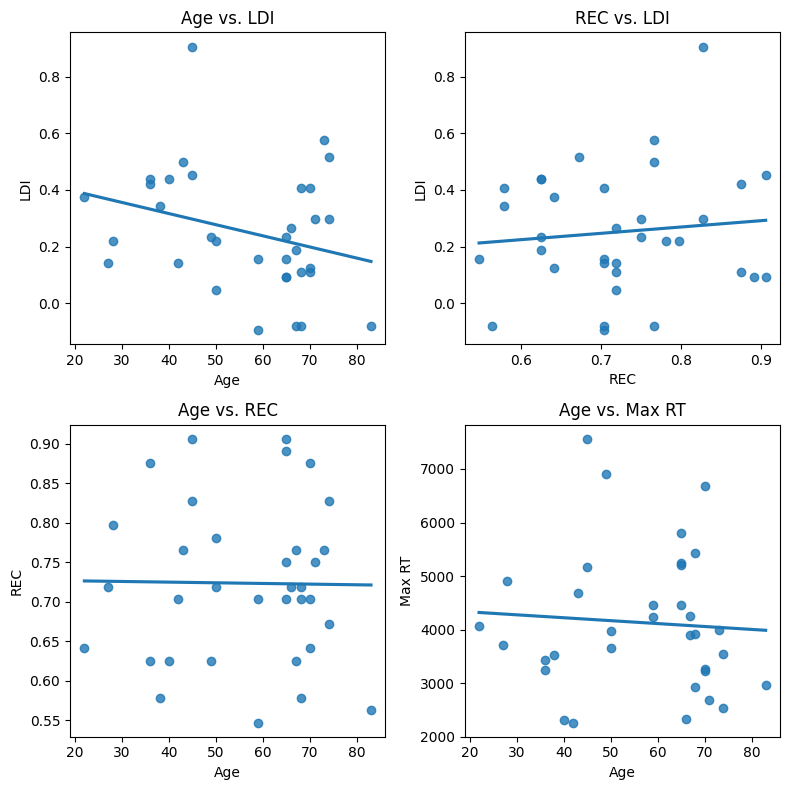

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# Plot 1: Age vs LDI
sns.regplot(data=filtered_df, x='Age', y='LDI', ax=axes[0][0], ci=None)
axes[0][0].set_title("Age vs. LDI")
axes[0][0].set_xlabel("Age")
axes[0][0].set_ylabel("LDI")

# Plot 2: REC vs LDI
sns.regplot(data=filtered_df, x='REC', y='LDI', ax=axes[0][1], ci=None)
axes[0][1].set_title("REC vs. LDI")
axes[0][1].set_xlabel("REC")
axes[0][1].set_ylabel("LDI")

# Plot 3: Age vs REC
sns.regplot(data=filtered_df, x='Age', y='REC', ax=axes[1][0], ci=None)
axes[1][0].set_title("Age vs. REC")
axes[1][0].set_xlabel("Age")
axes[1][0].set_ylabel("REC")

# Plot 4: Age vs Bad RT
sns.regplot(data=filtered_df, x='Age', y='Max RT', ax=axes[1][1], ci=None)
axes[1][1].set_title("Age vs. Max RT")
axes[1][1].set_xlabel("Age")
axes[1][1].set_ylabel("Max RT")

# Improve layout
# plt.tight_layout(rect=[0, 0, 0.95, 0.95])
# plt.suptitle("MST Participant Correlations")
plt.tight_layout()
plt.show()

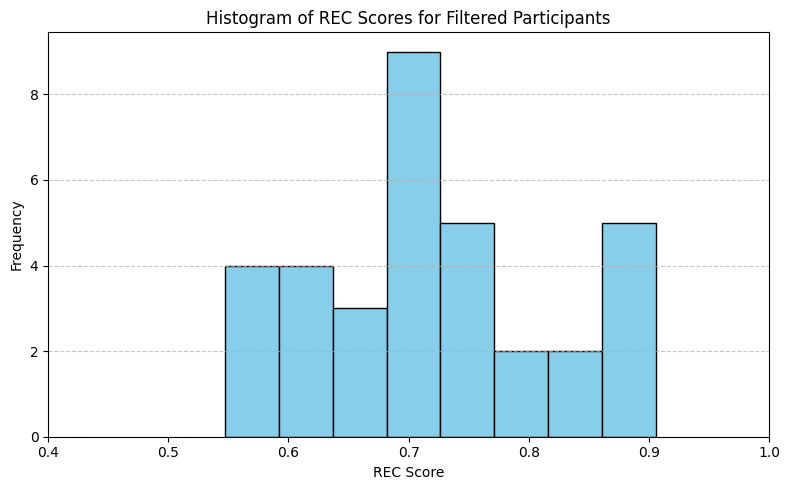

In [23]:
# Histogram of REC Scores for Filtered Participants

rec_values = pd.to_numeric(filtered_df['REC'], errors='coerce').dropna()

plt.figure(figsize=(8, 5))
plt.hist(rec_values, bins=8, color='skyblue', edgecolor='black')
plt.title('Histogram of REC Scores for Filtered Participants')
plt.xlabel('REC Score')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlim(0.4,1)
plt.tight_layout()
plt.show()

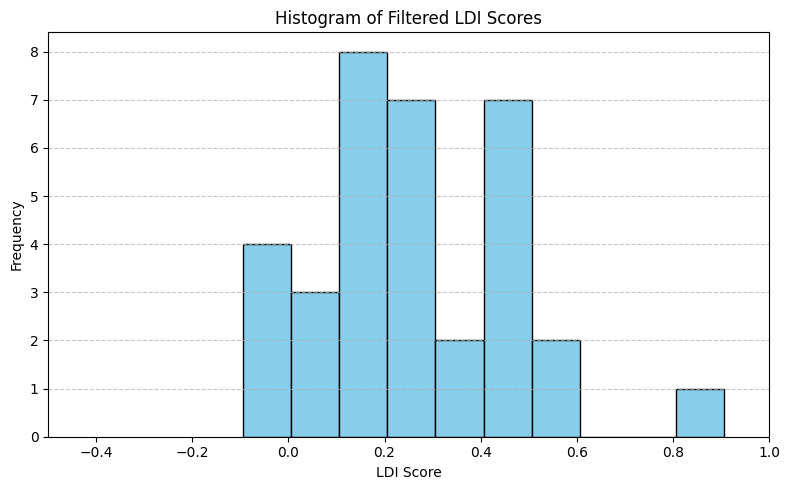

In [24]:
# Histogram of Filtered LDI Scores
rec_values = pd.to_numeric(filtered_df['LDI'], errors='coerce').dropna()

plt.figure(figsize=(8, 5))
plt.hist(rec_values, bins=10, color='skyblue', edgecolor='black')
plt.title('Histogram of Filtered LDI Scores')
plt.xlabel('LDI Score')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlim(-0.5,1)
plt.tight_layout()
plt.show()

In [25]:
filtered_df['LDI'].median()

np.float64(0.2265)

In [26]:
# I told you it would be here again
# Anyway anything after this is for Study Phase

df_study_trials = []
for result_folder in sorted(os.listdir(main_folder)):
    result_path = os.path.join(main_folder, result_folder)
    if os.path.isdir(result_path) and not result_folder.startswith('.'):
        if os.path.isdir(result_path):
            comp_folders = sorted(
                [f for f in os.listdir(result_path)
                if os.path.isdir(os.path.join(result_path, f))]
            )
            if len(comp_folders) >= 3:
                target_comp = comp_folders[3]
                data_path = os.path.join(result_path, target_comp, 'data.txt')
                if os.path.exists(data_path):
                    with open(data_path, 'r') as file:
                        contents = file.read()
                else:
                    print(f"No data.txt in {data_path}")
            else:
                print(f"Not enough comp folders in {result_path}")
        with open(data_path, 'r') as file:
            data = json.load(file)
        df_s = pd.DataFrame(data)
        df_study_trials.append(df_s)
df_study = pd.concat(df_study_trials)
df_study = df_study[df_study['stimulus'].fillna('').astype(str).str.startswith('https://starklab.')]

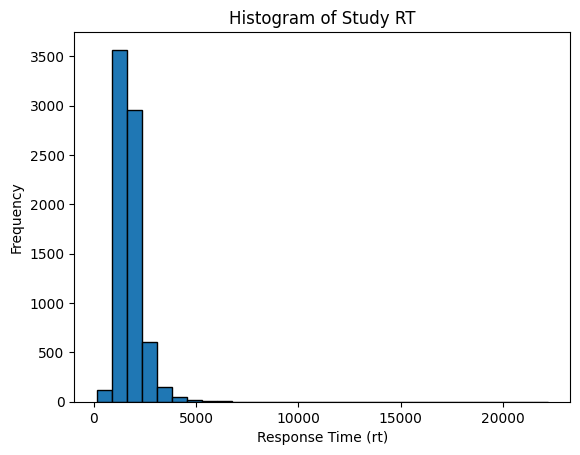

In [27]:
# Study RT Histogram

plt.hist(rt, bins=30, edgecolor='black')
plt.xlabel('Response Time (rt)')
plt.ylabel('Frequency')
plt.title('Histogram of Study RT')
plt.show()

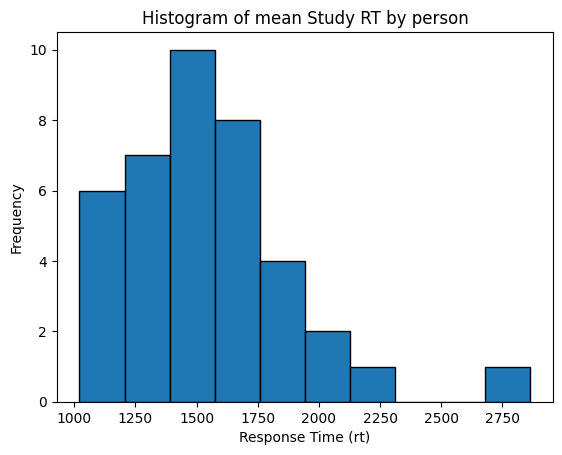

In [28]:
# Histogram of mean Study RT by person

rt_sub = df_study.groupby('subject')['rt'].mean()
plt.hist(rt_sub, bins=10, edgecolor='black')
plt.xlabel('Response Time (rt)')
plt.ylabel('Frequency')
plt.title('Histogram of mean Study RT by person')
plt.show()